In [24]:
import numpy as np
import pandas as pd
from tqdm import tqdm
import itertools
import matplotlib.pyplot as plt
import qutip as qt
import scipy.constants as sc
from joblib import Parallel, delayed
from functools import partial
from mode import CavityMode, QuantumMode, SNAILMode
from hamiltonian import Hamiltonian, QubitQubitSNAIL
from pulse import Pulse
from system import QuantumSystem

In [ ]:
   
def simulation_task(freq_amp_pair, system_hamiltonian, quantum_system, psi0, tlist, collapse_ops, drive_1_args):
    """Runs a simulation for a given frequency and amplitude."""
    freq, amp = freq_amp_pair

    # Define the drive with the new parameters
    drive = Pulse(omega=freq, amp=amp, phi=0)
    system_driven = system_hamiltonian.driven(drive)

    # Solve the system
    result = qt.mesolve(
        system_driven, psi0, tlist, collapse_ops,
        args=drive_1_args, options={"store_states": True, "progress_bar": None, "rtol": 1e-8, "atol": 1e-10, "nsteps": 1e6}
    )

    return result


def convert_array(param):
    """Ensure the input is a NumPy array."""
    if isinstance(param, (int, float)):  # If a single number, convert to an array
        return np.array([param])
    return np.array(param)  # If already a list/array, convert it to a NumPy array

if __name__ == '__main__':

    yaml_file = r"D:/Github/Qutip/Evan/system_params.yaml"

    # create the quantum system for simulation
    quantum_system = QuantumSystem.from_yaml(yaml_file)
    system_hamiltonian = QubitQubitSNAIL(quantum_system, use_RWA=False, use_TLS=False)
    psi0 = quantum_system.prepare_tensor_fock_state([(system_hamiltonian.q2_mode, 1)])
    collapse_ops = [i.collapse_operators()[0] for i in quantum_system.modes]

    width_d = 400
    tlist = np.linspace(0,1500, 15001)

    # Additional pulse args used in mesolve
    drive_1_args = {"shape": Pulse.smoothbox, "shape_params": {"t0": 300, "width": width_d}}

    detune = 2 * np.pi * 0.0
    amp_d = 10

    flist = convert_array(detune) + np.abs((system_hamiltonian.q1_mode.freq - system_hamiltonian.q2_mode.freq)) * 2 * np.pi
    alist = convert_array(amp_d)

    freq_amp_pairs = list(itertools.product(flist, alist))

    # drive_1 = Pulse(omega=w_d, amp = amp_d, phi = 0)

    # pulse_args = drive_1.smoothbox(t0 = 100, width = width_d, k=0.5, b=3)
    # system_driven = system_hamiltonian.driven(drive_1)
    

    # result = qt.mesolve(system_driven, psi0, tlist, collapse_ops, args=drive_1_args, options={"store_states":True, "progress_bar":"enhanced", "rtol":1e-8, "atol":1e-10, "nsteps":1e6})
    
    

    func = partial(simulation_task, Hamiltonian=system_hamiltonian, psi0=psi0, t_list=tlist, pulse_args=drive_1_args)
    results = Parallel(n_jobs=8, verbose=10)(delayed(func)(pair) for pair in freq_amp_pairs)


 Total run time:  44.05s*] Elapsed 44.05s / Remaining 00:00:00:00


TypeError: 'float' object is not iterable

In [19]:
 # calculate expectation values
psi_q2_0_i = quantum_system.mode_population_expectation(psi0, system_hamiltonian.q2_mode, 0)
psi_q2_0_f = quantum_system.mode_population_expectation(result.states[-1], system_hamiltonian.q2_mode, 0)
psi_q2_1_i = quantum_system.mode_population_expectation(psi0, system_hamiltonian.q2_mode, 1)
psi_q2_1_f = quantum_system.mode_population_expectation(result.states[-1], system_hamiltonian.q2_mode, 1)

print(f"overlap between psi0 and a prepped initial state says Q2 is in |g> = {psi_q2_0_i:.3f} \noverlap between final state and a prepped initial state says Q2 is in |g> = {psi_q2_0_f:.3f}")
print(f"overlap between psi0 and a prepped initial state says Q2 is in |e> = {psi_q2_1_i:.3f} \noverlap between final state and a prepped initial state says Q2 is in |e> = {psi_q2_1_f:.3f}")

overlap between psi0 and a prepped initial state says Q2 is in |g> = 0.000 
overlap between final state and a prepped initial state says Q2 is in |g> = 0.018
overlap between psi0 and a prepped initial state says Q2 is in |e> = 1.000 
overlap between final state and a prepped initial state says Q2 is in |e> = 0.981


In [20]:
psi_q1_0_i = quantum_system.mode_population_expectation(psi0, system_hamiltonian.q1_mode, 0)
psi_q1_0_f = quantum_system.mode_population_expectation(result.states[-1], system_hamiltonian.q1_mode, 0)
psi_q1_1_i = quantum_system.mode_population_expectation(psi0, system_hamiltonian.q1_mode, 1)
psi_q1_1_f = quantum_system.mode_population_expectation(result.states[-1], system_hamiltonian.q1_mode, 1)

print(f"overlap between psi0 and a prepped initial state says Q1 is in |g> = {psi_q1_0_i:.3f} \noverlap between final state and a prepped initial state says Q1 is in |g> = {psi_q1_0_f:.3f}")
print(f"overlap between psi0 and a prepped initial state says Q1 is in |e> = {psi_q1_1_i:.3f} \noverlap between final state and a prepped initial state says Q1 is in |e> = {psi_q1_1_f:.3f}")

overlap between psi0 and a prepped initial state says Q1 is in |g> = 1.000 
overlap between final state and a prepped initial state says Q1 is in |g> = 0.934
overlap between psi0 and a prepped initial state says Q1 is in |e> = 0.000 
overlap between final state and a prepped initial state says Q1 is in |e> = 0.063


In [21]:
def get_pop_dist(states, mode, quantum_system):
    population = np.zeros((len(states), mode.dim))
    for k, state in enumerate(tqdm(states)):
        for i in range(mode.dim):
            population[k][i] = quantum_system.mode_population_expectation(state, mode, i)

    return population

s_pop = get_pop_dist(result.states, system_hamiltonian.snail_mode, quantum_system)
q1_pop = get_pop_dist(result.states, system_hamiltonian.q1_mode, quantum_system)
q2_pop = get_pop_dist(result.states, system_hamiltonian.q2_mode, quantum_system)

100%|██████████| 15001/15001 [00:11<00:00, 1256.50it/s]


Text(0.5, 0, 'time (ns)')

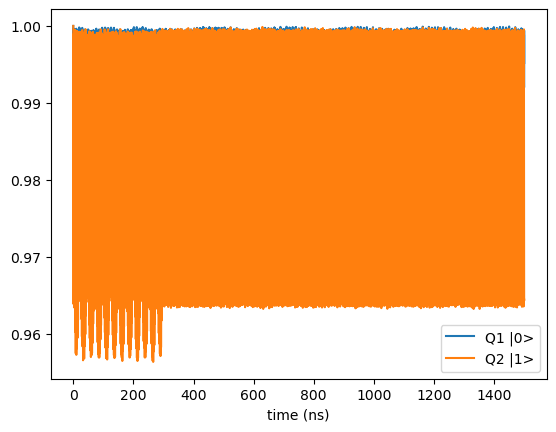

In [13]:
plt.figure("mode population")
# plt.plot(tlist, s_pop[:, 0], label='SNAIL |0>')
# plt.plot(tlist, s_pop[:, 1], label='SNAIL |1>')
# plt.plot(t_list, s_pop[:, 2], label='SNAIL |2>')
plt.plot(tlist, q1_pop[:, 0], label='Q1 |0>')
plt.plot(tlist, q2_pop[:, 1], label='Q2 |1>')
plt.legend()
plt.xlabel("time (ns)")